In [19]:
import pandas as pd
import time
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef
import os
import seaborn as sns
sns.set_theme(style="white", font_scale=1.1, rc={'xtick.bottom': True, 'ytick.left': True})


# Go up one directory to get to master/
project_root = str(Path.cwd().parent)
sys.path.append(project_root)

ist leave one group out cross val!

In [20]:
def get_solutions_allruns_rollOCT(name_cohort: str, n_estimators = 500, depth_tree = 5, runs = 10, subset_feat = 'sqrt') -> dict:
    dir_path = f'../microbiome_data/taxa_all_logo/refactored_random_forest/n{n_estimators}_d{depth_tree}_{subset_feat}'
    sol_dict = {}
    for run in range(1,runs+1):
        sol_dict[run] = pd.read_csv(f"{dir_path}/test_['{name_cohort}']/result_test_run{run}.csv")
    return sol_dict

In [21]:
def get_solutions_allruns_sklearn(name_cohort: str, n_estimators = 500, depth_tree = 5, runs = 10, subset_feat = 'sqrt') -> dict:
    dir_path = f'../microbiome_data/taxa_all_logo/sklearn_random_forest/n{n_estimators}_d{depth_tree}_{subset_feat}'
    sol_dict = {}
    for run in range(1,runs+1):
        sol_dict[run] = pd.read_csv(f"{dir_path}/test_['{name_cohort}']/result_test_run{run}.csv")
    return sol_dict

In [22]:
def get_mcc_list_rollOCT(cohort_name, n_estimators = 500, depth_tree = 5, runs = 10, subset_feat = 'sqrt'):
    sol_dict = get_solutions_allruns_rollOCT(name_cohort = cohort_name, n_estimators = n_estimators, depth_tree = depth_tree, runs = runs, subset_feat = subset_feat)
    
    mcc_scores = []

    for run in range(1, runs+1):
        y_true_test = sol_dict[run]['y']
        y_predict_test = sol_dict[run]['prediction']
        
        mcc_test = matthews_corrcoef(y_true_test, y_predict_test) #For a multiclass problem, sklearn.metrics.matthews_corrcoef returns a single float value representing the overall Matthews correlation coefficient (MCC) across all classes
        mcc_scores.append(mcc_test)
    return mcc_scores

In [23]:
def get_mcc_list_sklearn(cohort_name, n_estimators = 500, depth_tree = 5, runs = 10, subset_feat = 'sqrt'):
    sol_dict = get_solutions_allruns_sklearn(name_cohort = cohort_name, n_estimators = n_estimators, depth_tree = depth_tree, runs = runs, subset_feat = subset_feat)
    
    mcc_scores = []

    for run in range(1, runs+1):
        y_true_test = sol_dict[run]['y']
        y_predict_test = sol_dict[run]['prediction']
        
        mcc_test = matthews_corrcoef(y_true_test, y_predict_test) #For a multiclass problem, sklearn.metrics.matthews_corrcoef returns a single float value representing the overall Matthews correlation coefficient (MCC) across all classes
        mcc_scores.append(mcc_test)
    return mcc_scores

In [24]:
def mcc_dict_both_trees(list_cohorts, n_estimators = 500, depth_tree = 5, runs = 10, subset_feat = 'sqrt'):
    mcc_dict = dict() #entry contains list with #folds values
    for i, cohort in enumerate(list_cohorts):
        mcc_dict[cohort] = dict()
        mcc_scores_rollOCT = get_mcc_list_rollOCT(cohort_name = cohort, n_estimators = n_estimators, depth_tree = depth_tree, runs = runs, subset_feat = subset_feat)
        mcc_scores_sklearn = get_mcc_list_sklearn(cohort_name = cohort, n_estimators = n_estimators, depth_tree = depth_tree, runs = runs, subset_feat = subset_feat)
        mcc_dict[cohort]['rollOCT_random_forest'] = mcc_scores_rollOCT
        mcc_dict[cohort]['sklearn_random_forest'] = mcc_scores_sklearn
    return mcc_dict

In [25]:
def figure_mcc_seaborne(list_cohorts, alias_dict = dict(), n_estimators = 500, runs = 10, depth_tree = 5, subset_feat = 'sqrt'):
    if subset_feat == None:
        var_name = 'None'
    else:
        var_name = subset_feat
    mcc_dict = mcc_dict_both_trees(list_cohorts = list_cohorts, n_estimators = n_estimators, depth_tree = depth_tree , runs = runs, subset_feat = subset_feat)
    data = []
    for cohort in list_cohorts:
        for mcc_type in ['sklearn_random_forest', 'rollOCT_random_forest']:
            for value in mcc_dict[cohort][mcc_type]:
                data.append({
                    'Cohort': alias_dict.get(cohort, cohort),
                    'Type': mcc_type,
                    'mcc': value
                })
    df = pd.DataFrame(data)

    print(data)

    fig = plt.figure(figsize=(17, 6))
    sns.boxplot(x='Cohort', y='mcc', hue='Type', data=df, linewidth=1, width=0.6, dodge=True, palette='colorblind')
    plt.ylim(-0.25, 1)
    plt.title(f"mcc; {n_estimators} estimators with tree depth {depth_tree}; sqrt(#features) selection each split")
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    fig.savefig(os.path.join('../microbiome_data/taxa_all_logo', f'boxplot_taxa_all_n{n_estimators}_d{depth_tree}_{var_name}.png'))
    fig.savefig(os.path.join('../microbiome_data/taxa_all_logo', f'boxplot_taxa_all_n{n_estimators}_d{depth_tree}_{var_name}.pdf'), format='pdf', bbox_inches='tight')
    plt.show()

In [26]:
cohort_list = ['Austria1', 'Brazil1', 'Canada1', 'China1', 'China2', 'China3', 'China4', 'China5', 'France1', 'Germany1', 'Germany2', 'India1', 'India2', 'Italy1', 'Japan1', 'USA1', 'USA2']

alias_dict = {
    'Austria1' : 'Austria1',
    'Brazil1' : 'Brazil1',
    'Canada1' : 'Canada1',
    'China1' : 'China1',
    'China2' : 'China2',
    'China3' : 'China3',
    'China4' : 'China4',
    'China5' : 'China5',
    'France1' : 'France1',
    'Germany1' : 'Ger1',
    'Germany2' : 'Ger2',
    'India1' : 'India1',
    'India2' : 'India2',
    'Italy1' : 'Italy1',
    'Japan1' : 'Japan1',
    'USA1' : 'USA1',
    'USA2' : 'USA2'
}

[{'Cohort': 'Austria1', 'Type': 'sklearn_random_forest', 'mcc': 0.40865702111688224}, {'Cohort': 'Austria1', 'Type': 'sklearn_random_forest', 'mcc': 0.44583647412412886}, {'Cohort': 'Austria1', 'Type': 'sklearn_random_forest', 'mcc': 0.44583647412412886}, {'Cohort': 'Austria1', 'Type': 'sklearn_random_forest', 'mcc': 0.39044318737504746}, {'Cohort': 'Austria1', 'Type': 'sklearn_random_forest', 'mcc': 0.4720805907942223}, {'Cohort': 'Austria1', 'Type': 'sklearn_random_forest', 'mcc': 0.44583647412412886}, {'Cohort': 'Austria1', 'Type': 'sklearn_random_forest', 'mcc': 0.44583647412412886}, {'Cohort': 'Austria1', 'Type': 'sklearn_random_forest', 'mcc': 0.40865702111688224}, {'Cohort': 'Austria1', 'Type': 'sklearn_random_forest', 'mcc': 0.40865702111688224}, {'Cohort': 'Austria1', 'Type': 'sklearn_random_forest', 'mcc': 0.43608951098657317}, {'Cohort': 'Austria1', 'Type': 'rollOCT_random_forest', 'mcc': 0.4186884285449038}, {'Cohort': 'Austria1', 'Type': 'rollOCT_random_forest', 'mcc': 0.3

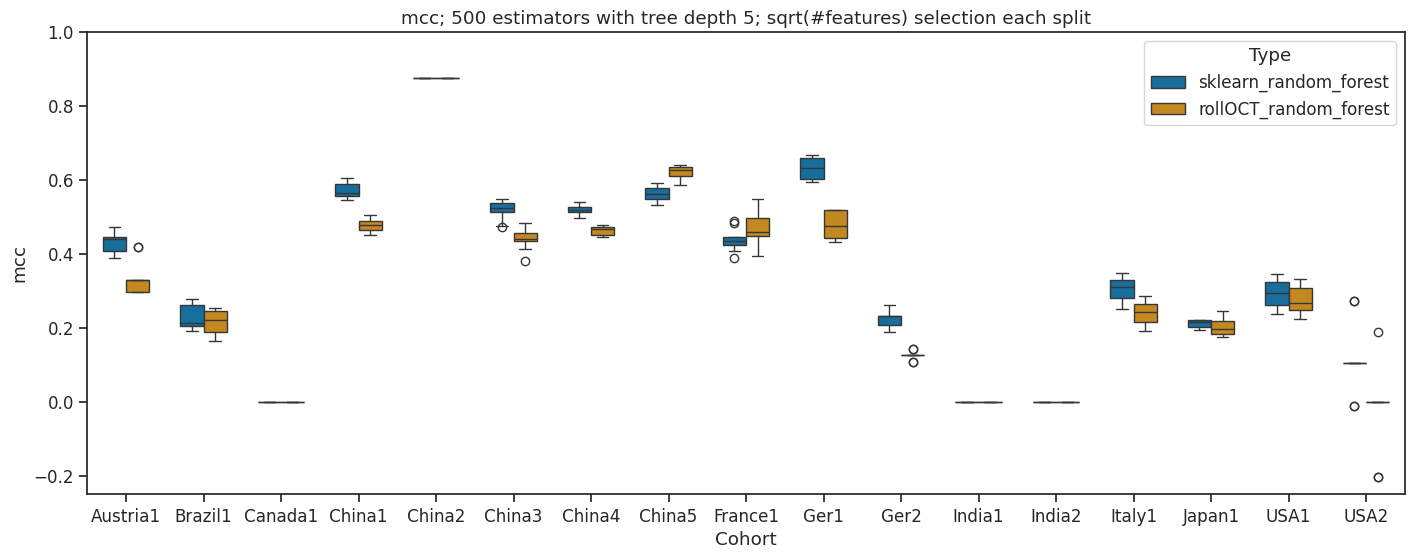

In [27]:
figure_mcc_seaborne(list_cohorts = cohort_list, alias_dict = alias_dict, n_estimators = 500, runs = 10, depth_tree = 5, subset_feat = 'sqrt')